In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import missingno as msno
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    classification_report
)

In [2]:
RANDOM_STATE = 42
# THRESHOLD_PERCENTILE = 85 

In [3]:
df = pd.read_csv('All_dataset.csv', encoding="utf-8", encoding_errors="replace")

In [4]:
# removing leading/trailing whitespace in col names
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

# fix the encoding issues in the label
df['Label'] = df['Label'] \
    .str.replace('ï¿½', '-', regex=False) \
    .str.replace('�', '-', regex=False) \
    .str.strip()

In [5]:
df['AttackBinary'] = df['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else 'Attack')

In [6]:
# handle duplicates
df.drop_duplicates(inplace = True)


# handle missing values
missing_values = df.isnull().sum()
missing_values

print(missing_values.loc[missing_values > 0])


# check infinity values
numeric_cols = df.select_dtypes(include = np.number).columns
inf_count = np.isinf(df[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s    353
dtype: int64
Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [7]:
inf_rows = df[np.isinf(df['Flow Bytes/s']) | np.isinf(df['Flow Packets/s'])]
print('Rows with infinity values in \'Flow Bytes/s\' or \'Flow Packets/s\':')
display(inf_rows[['Flow Bytes/s', 'Flow Packets/s', 'Label']].sample(5))

Rows with infinity values in 'Flow Bytes/s' or 'Flow Packets/s':


,Flow Bytes/s,Flow Packets/s,Label
1602488,inf,inf,BENIGN
1402408,inf,inf,BENIGN
1338154,inf,inf,BENIGN
2529098,inf,inf,PortScan
1962286,inf,inf,BENIGN


In [8]:
# replace infinite values with NaN
print(f'Initial missing values: {df.isna().sum().sum()}')

df.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {df.isna().sum().sum()}')

Initial missing values: 353
Missing values after processing infinite values: 3128


In [9]:
missing = df.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64


In [10]:
fb_median = df['Flow Bytes/s'].median()
fp_median = df['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', fb_median)
print('Median of Flow Packets/s: ', fp_median)

# Fill missing values with median
df['Flow Bytes/s'].fillna(fb_median, inplace = True)
df['Flow Packets/s'].fillna(fp_median, inplace = True)

Median of Flow Bytes/s:  3715.0378579999997
Median of Flow Packets/s:  69.742244285


C:\Users\USER\AppData\Local\Temp\ipykernel_30092\210869509.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Flow Bytes/s'].fillna(fb_median, inplace = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_30092\210869509.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [11]:
print('Number of \'Flow Bytes/s\' missing values:', df['Flow Bytes/s'].isna().sum())
print('Number of \'Flow Packets/s\' missing values:', df['Flow Packets/s'].isna().sum())

Number of 'Flow Bytes/s' missing values: 0
Number of 'Flow Packets/s' missing values: 0


In [12]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack - Brute Force': 'Web Attack',
    'Web Attack - XSS': 'Web Attack',
    'Web Attack - Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

In [13]:
df['Attack Type'] = df['Label'].map(attack_map)

In [14]:
df['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [15]:
df.drop('Label', axis = 1, inplace = True)

df['AttackBinary'].unique()

df['Attack Type'].unique()

array(['BENIGN', 'Brute Force', 'DoS', 'Heartbleed', 'Web Attack',
       'Infiltration', 'Bot', 'Port Scan', 'DDoS'], dtype=object)

In [16]:
# Dropping columns with only one unique value
num_unique = df.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = df[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

In [17]:
df['AttackBinary'] = df['AttackBinary'].map({'Normal': 0, 'Attack': 1})

In [18]:
data.shape


(2522362, 72)

**Model Training**

In [19]:
y = data["AttackBinary"]

In [20]:
drop_cols = ["AttackBinary", "Attack Type" ]

In [21]:
X = data.drop(columns=[c for c in drop_cols if c in data.columns])

In [22]:
print("Total features:", X.shape[1])

Total features: 70


In [23]:
from sklearn.decomposition import PCA

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # keep 95% variance
X_pca = pca.fit_transform(X_scaled)

print("Original features:", X.shape[1])
print("PCA components:", X_pca.shape[1])

Original features: 70
PCA components: 25


In [26]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)

# Find top contributors overall
loadings["importance"] = loadings.abs().sum(axis=1)
top_features = loadings.sort_values("importance", ascending=False)

top_features.head(25)  

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,importance
Bwd Packets/s,-0.026250,-0.000727,0.009159,0.010652,0.108137,0.016021,0.000495,-0.007137,-0.034246,0.043841,...,0.169733,0.134500,0.280776,0.487535,-0.172648,0.272314,0.549083,-0.088907,-0.216600,3.165665
Flow Bytes/s,-0.004169,0.002042,-0.004042,0.065687,0.125912,-0.035381,-0.002434,0.073187,0.123506,-0.175062,...,0.054219,0.037054,0.076618,-0.436468,0.436658,-0.440586,0.505404,0.018408,-0.187535,3.121195
Fwd Packet Length Min,-0.030929,-0.001519,0.036930,0.029768,-0.103567,-0.221161,-0.016148,-0.065513,0.246785,-0.008664,...,0.111021,0.096051,0.442003,0.064327,0.100129,0.004720,-0.327650,0.394945,-0.429355,3.048770
Down/Up Ratio,-0.025201,0.001536,-0.008995,-0.031761,-0.125286,-0.155293,-0.007773,-0.078290,0.065571,0.171915,...,0.170867,0.049160,0.201186,0.097782,0.015953,-0.286760,0.045062,0.006977,0.542655,2.881690
Active Std,0.027859,0.014122,0.011975,0.117664,-0.094820,0.294481,-0.002745,-0.024838,0.170591,0.008315,...,0.000915,0.468306,-0.140932,-0.253708,-0.187414,0.191238,0.137670,0.303224,0.123066,2.838147
FIN Flag Count,0.092941,-0.010899,0.024660,-0.045409,0.032701,-0.018256,-0.007039,-0.229909,-0.080609,-0.150244,...,0.268205,-0.292010,-0.309474,-0.078927,-0.003046,0.178762,0.084644,0.275369,-0.223176,2.814837
Init_Win_bytes_backward,-0.017999,0.002731,-0.001983,0.046728,0.052532,0.081413,0.008850,0.021794,-0.173793,0.179671,...,-0.048468,-0.031744,0.225850,-0.242949,0.580751,0.633558,-0.028764,-0.118090,0.111459,2.791131
Idle Std,0.067323,-0.000071,-0.003820,0.074880,0.024203,-0.020069,-0.005981,-0.055699,0.022723,0.054867,...,-0.119102,0.336515,-0.396866,0.529879,0.522329,-0.102063,-0.006394,0.181102,0.027210,2.752604
Active Min,0.036134,0.026176,-0.000519,0.105856,-0.069455,0.273172,-0.008460,-0.038277,0.299557,0.184570,...,0.013475,-0.438993,0.049719,0.174457,0.128927,-0.117460,-0.085017,-0.177701,-0.085836,2.707756
Bwd IAT Total,0.138537,0.000016,0.130223,0.122106,-0.103865,0.160272,0.009005,-0.047101,-0.143576,-0.211134,...,0.043144,0.166630,0.043758,0.001405,0.012392,-0.099583,-0.145201,-0.357683,-0.194790,2.536355


In [27]:
final_ml_features = [
    "Bwd Packets/s",
    "Flow Bytes/s",
    "Fwd Packet Length Min",
    "Down/Up Ratio",
    "Active Std",
    "FIN Flag Count",
    "Init_Win_bytes_backward",
    "Idle Std",
    "Active Min",
    "Bwd IAT Total",
    "Init_Win_bytes_forward",
    "SYN Flag Count",
    "Fwd PSH Flags",
    "Fwd Packets/s",
    "Flow Packets/s",
    "URG Flag Count",
    "Bwd Packet Length Min",
    "PSH Flag Count",
    "Flow IAT Min",
    "Bwd IAT Std",
    "Active Max",
    "Min Packet Length",
    "Active Mean",
    "Flow Duration",
    "Destination Port"
]


In [29]:
# Filter to only include features that exist in the dataframe
available_features = [f for f in final_ml_features if f in df.columns]
print(f"\n📊 Using {len(available_features)} selected features out of {len(final_ml_features)} requested")
print(f"Features used: {available_features}\n")


📊 Using 25 selected features out of 25 requested
Features used: ['Bwd Packets/s', 'Flow Bytes/s', 'Fwd Packet Length Min', 'Down/Up Ratio', 'Active Std', 'FIN Flag Count', 'Init_Win_bytes_backward', 'Idle Std', 'Active Min', 'Bwd IAT Total', 'Init_Win_bytes_forward', 'SYN Flag Count', 'Fwd PSH Flags', 'Fwd Packets/s', 'Flow Packets/s', 'URG Flag Count', 'Bwd Packet Length Min', 'PSH Flag Count', 'Flow IAT Min', 'Bwd IAT Std', 'Active Max', 'Min Packet Length', 'Active Mean', 'Flow Duration', 'Destination Port']



In [28]:
y = df["AttackBinary"]

In [30]:
X = df[available_features]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

In [32]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
CONTAMINATION = len(y_train[y_train == 1]) / len(y_train)

print(f'Contamination in training set: {CONTAMINATION:.4f}')

Contamination in training set: 0.1688


In [34]:
iso_forest = IsolationForest(
    n_estimators=300,
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE,
    max_samples='auto',
    n_jobs=-1
)

In [44]:
train_df = df[df["AttackBinary"] == 0]

X_train = train_df[final_ml_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = IsolationForest(
    n_estimators=300,
    contamination=CONTAMINATION,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled)


,n_estimators,300
,max_samples,'auto'
,contamination,0.15
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [35]:
iso_forest.fit(X_train_scaled)

,n_estimators,300
,max_samples,'auto'
,contamination,0.16884080343368738
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [45]:
train_scores = -iso_forest.decision_function(X_train_scaled)
test_scores = -iso_forest.decision_function(X_test_scaled)

In [28]:
# attack_ratio = float(y_train.mean() * 100)
# THRESHOLD_PERCENTILE = round(100 - attack_ratio, 2)
# threshold = np.percentile(train_scores, THRESHOLD_PERCENTILE)
# print(f'Threshold at {THRESHOLD_PERCENTILE} percentile: {threshold:.4f}')

In [52]:
THRESHOLD_PERCENTILE = 61.0
threshold = 0.0865
print(f'Threshold at {THRESHOLD_PERCENTILE} percentile: {threshold:.4f}')

Threshold at 61.0 percentile: 0.0865


F1-optimal threshold

In [51]:
from sklearn.metrics import f1_score
import numpy as np

# Use FULL dataset for threshold tuning
X_val = df[final_ml_features]
X_val_scaled = scaler.transform(X_val)

val_scores = model.decision_function(X_val_scaled)
y_true = df['AttackBinary']   # 0 = BENIGN, 1 = ATTACK

percentiles = np.arange(60, 95, 0.5)
best_f1 = 0
best_p = None
best_threshold = None

for p in percentiles:
    t = np.percentile(val_scores, p)
    preds = (val_scores >= t).astype(int)

    f1 = f1_score(y_true, preds)

    if f1 > best_f1:
        best_f1 = f1
        best_p = p
        best_threshold = t

print(f"Best percentile: {best_p}")
print(f"Best threshold: {best_threshold:.4f}")
print(f"Validation F1: {best_f1:.4f}")


Best percentile: 61.0
Best threshold: 0.0865
Validation F1: 0.1267


ROC-based threshold

In [ ]:
# from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(y_train, train_scores)
# j_scores = tpr - fpr
# idx = np.argmax(j_scores)

# best_threshold = thresholds[idx]
# print(f'Optimal threshold by Youden\'s J statistic: {best_threshold:.4f}')

Optimal threshold by Youden's J statistic: -0.0073


In [49]:
# Prediction logic: If score > threshold, it's an Attack (1)
y_pred = (test_scores >= threshold).astype(int)

**Evaluation**

In [54]:
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, test_scores)
avg_precision = average_precision_score(y_test, test_scores)
precision, recall, _ = precision_recall_curve(y_test, test_scores)

In [55]:
print("\n==============================")
print("Isolation Forest Evaluation")
print("==============================")
print(f"F1 Score        : {f1:.4f}")
print(f"ROC-AUC         : {roc_auc:.4f}")
print(f"Avg Precision   : {avg_precision:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["BENIGN", "ATTACK"]))


Isolation Forest Evaluation
F1 Score        : 0.1626
ROC-AUC         : 0.5086
Avg Precision   : 0.1690

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.83      0.81      0.82    419297
      ATTACK       0.15      0.17      0.16     85176

    accuracy                           0.70    504473
   macro avg       0.49      0.49      0.49    504473
weighted avg       0.71      0.70      0.71    504473



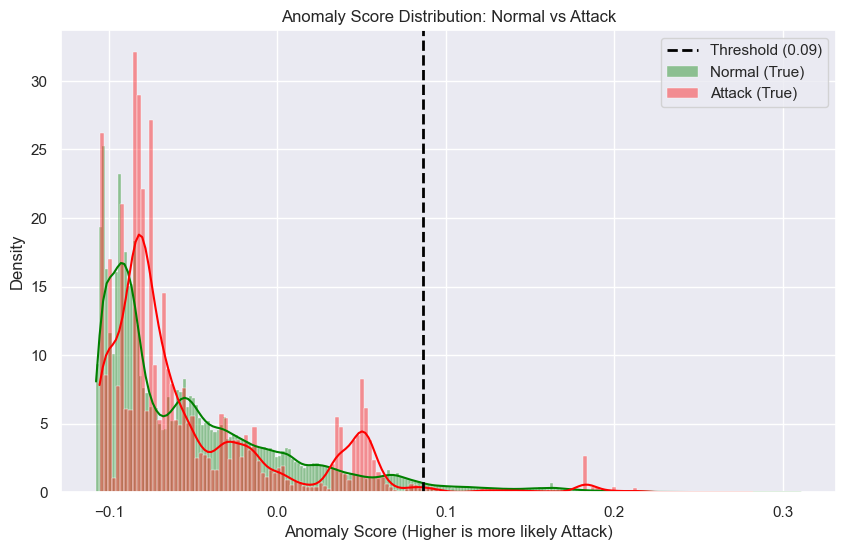

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(test_scores[y_test==0], color='green', label='Normal (True)', kde=True, stat="density", alpha=0.4)
sns.histplot(test_scores[y_test==1], color='red', label='Attack (True)', kde=True, stat="density", alpha=0.4)
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.title('Anomaly Score Distribution: Normal vs Attack')
plt.xlabel('Anomaly Score (Higher is more likely Attack)')
plt.legend()
plt.show()

In [40]:
set_selected = set(SELECTED_FEATURES)
set_x = set(X.columns.tolist())

print("✔ In SELECTED_FEATURES but NOT in X.columns:", set_selected - set_x)
print("✔ In X.columns but NOT in SELECTED_FEATURES:", set_x - set_selected)


✔ In SELECTED_FEATURES but NOT in X.columns: set()
✔ In X.columns but NOT in SELECTED_FEATURES: set()


In [41]:
print("Order matches:", SELECTED_FEATURES == X.columns.tolist())


Order matches: True


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import (
#     f1_score, roc_auc_score, average_precision_score,
#     precision_score, recall_score, confusion_matrix
# )
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# # =====================================================
# # CONFIGURATION
# # =====================================================

# print("="*70)
# print("🔧 HYPERPARAMETER + THRESHOLD TUNING (ISOLATION FOREST)")
# print("="*70)

# actual_contamination = y_train.sum() / len(y_train)

# print(f"\n📊 Dataset Statistics:")
# print(f"Training samples: {len(y_train)}")
# print(f"Test samples: {len(y_test)}")
# print(f"Attack rate: {actual_contamination:.4f} ({actual_contamination*100:.2f}%)")

# # =====================================================
# # PARAMETER GRID
# # =====================================================

# param_grid = {
#     "n_estimators": [200, 300, 400],
#     "max_samples": ["auto", 0.6, 0.8],
#     "max_features": [0.6, 0.8, 1.0],
#     "contamination": [0.12, 0.15, 0.18],
#     "threshold_percentile": [75, 80, 83, 85, 88]
# }

# # =====================================================
# # GRID SEARCH
# # =====================================================

# results = []
# best_f1_attack = 0
# best_config = None

# print("\n🚀 Starting grid search...\n")

# for n_estimators in param_grid["n_estimators"]:
#     for max_samples in param_grid["max_samples"]:
#         for max_features in param_grid["max_features"]:
#             for contamination in param_grid["contamination"]:

#                 try:
#                     model = IsolationForest(
#                         n_estimators=n_estimators,
#                         max_samples=max_samples,
#                         max_features=max_features,
#                         contamination=contamination,
#                         random_state=42,
#                         n_jobs=-1
#                     )

#                     model.fit(X_train_scaled)

#                     train_scores = -model.decision_function(X_train_scaled)
#                     test_scores = -model.decision_function(X_test_scaled)

#                     for percentile in param_grid["threshold_percentile"]:
#                         threshold = np.percentile(train_scores, percentile)
#                         y_pred = (test_scores >= threshold).astype(int)

#                         # Metrics
#                         f1_attack = f1_score(y_test, y_pred, pos_label=1)
#                         precision_attack = precision_score(y_test, y_pred, pos_label=1)
#                         recall_attack = recall_score(y_test, y_pred, pos_label=1)

#                         f1_benign = f1_score(y_test, y_pred, pos_label=0)
#                         roc_auc = roc_auc_score(y_test, test_scores)
#                         pr_auc = average_precision_score(y_test, test_scores)

#                         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#                         fpr = fp / (fp + tn)
#                         balanced_acc = ((tp / (tp + fn)) + (tn / (tn + fp))) / 2

#                         combined_score = 0.7 * f1_attack + 0.3 * roc_auc

#                         results.append({
#                             "n_estimators": n_estimators,
#                             "max_samples": max_samples,
#                             "max_features": max_features,
#                             "contamination": contamination,
#                             "threshold_percentile": percentile,
#                             "threshold": threshold,
#                             "f1_attack": f1_attack,
#                             "precision_attack": precision_attack,
#                             "recall_attack": recall_attack,
#                             "f1_benign": f1_benign,
#                             "roc_auc": roc_auc,
#                             "pr_auc": pr_auc,
#                             "balanced_accuracy": balanced_acc,
#                             "fpr": fpr,
#                             "combined_score": combined_score
#                         })

#                         if f1_attack > best_f1_attack:
#                             best_f1_attack = f1_attack
#                             best_config = results[-1]

#                 except Exception as e:
#                     print(f"⚠️ Skipped config due to error: {e}")

# print("\n✅ Grid search completed!")

# results_df = pd.DataFrame(results)


🔧 HYPERPARAMETER + THRESHOLD TUNING (ISOLATION FOREST)

📊 Dataset Statistics:
Training samples: 2017889
Test samples: 504473
Attack rate: 0.1688 (16.88%)

🚀 Starting grid search...



In [ ]:
best_row = results_df.loc[results_df['f1_attack'].idxmax()]

print("\n🥇 BEST CONFIGURATION (Attack-Focused)")
print("-"*60)
print(best_row)

In [33]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.
